<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from pathlib import Path
from google.colab import files, drive
from collections import defaultdict

import re
import random as rn
import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, LSTM, GRU, Embedding, RepeatVector, TimeDistributed
from keras.layers import Bidirectional as Bi
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

RS = 77
rn.seed(RS)
# tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'transcriptions'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Let's look at the data in given file

In [2]:
with data_file.open() as f:  
    print(list(f.readline()))

['а', 'у', 'к', 'ц', 'и', 'о', 'н', 'ы', ' ', 'н', 'а', ' ', 'д', 'е', 'ш', 'ё', 'в', 'о', 'е', ' ', 'ж', 'и', 'л', 'ь', 'ё', ' ', 'п', 'р', 'о', 'в', 'о', 'д', 'я', 'т', 'с', 'я', ' ', 'р', 'е', 'г', 'у', 'л', 'я', 'р', 'н', 'о', '\t', '%', '%', ' ', 'a', ' ', 'u', ' ', 'k', ' ', 't', 's', ' ', 'y', ' ', 'o', '1', ' ', 'n', ' ', 'a', 'x', ' ', '#', ' ', 'n', ' ', 'a', 'x', "'", ' ', '_', ' ', 'd', "'", ' ', "'", 'i', ' ', 's', 'h', ' ', 'o', '1', ' ', 'v', ' ', 'a', 'x', "'", ' ', 'j', 'a', 'x', ' ', '#', ' ', 'z', 'h', ' ', 'y', "'", ' ', 'l', "'", ' ', 'j', "'", ' ', "'", 'o', '1', ' ', '#', ' ', 'p', ' ', 'r', ' ', 'a', ' ', 'v', ' ', 'o', "'", '1', ' ', 'd', "'", ' ', "'", 'a', 'x', ' ', 't', 's', ' ', 't', 's', ' ', 'a', 'x', "'", ' ', '#', ' ', 'r', "'", ' ', "'", 'i', 'x', ' ', 'g', ' ', 'u', "'", ' ', 'l', "'", ' ', "'", 'a', '1', ' ', 'r', ' ', 'n', ' ', 'a', ' ', '%', '%', '\n']


#### Notice that:
1. russian sentence is separated from transcript with '\t'
2. the begining and the end of transcript part are marked by '%%'

### Let's read the data and split it into rus and trans

In [3]:
rus_trn = []
with data_file.open() as f:  
  for line in f: 
    rus, trn = line.split('\t')
    rus_trn.append([rus.strip(), trn.strip()])

print(f'Number of sentences in corpus: {len(rus_trn)}')

Number of sentences in corpus: 50277


##### Let's look at some sentences


In [4]:
a,b,c = np.random.choice(len(rus_trn), 3)

print(rus_trn[a][0])
print(rus_trn[a][1])
print(rus_trn[b][0])
print(rus_trn[b][1])
print(rus_trn[c][0])
print(rus_trn[c][1])

веб-операторы обязаны ознакомить пользователя с политикой по сбору персональной информации
%% v' 'e1 p a' p' 'i r a1 t ax r ax # a' b' 'a1 z ax n ax # a z n a k o'1 m' 'ix' t' # p o'1 l' z ax v ax' t' 'ix' l' 'ax # s _ p a' l' 'i'1 t' 'ix k ax' j' # p a _ z b o1 r ux' # p' 'ix r s a n a'1 l' n ax' j' # 'i n f a r m a1 ts ax' i %%
цена мартовского контракта на нефть в торговой системе поднялась
%% ts y n a1 # m a1 r t ax f s k ax v ax # k a n t r a1 k t ax # n a' _ n' 'e1 f t' # f _ t a r g o1 v ax' j' # s' 'i' s' t' 'e'1 m' 'ix # p ax' d' n' 'i l a'1 s' %%
в августе прошлого года был достроен храм христа спасителя
%% v _ a1 v g ux' s' t' 'ix # p r o1 sh l ax v ax # g o1 d ax # b y1 l # d a s t r o'1 jax n # h r a1 m # h r' 'i s t a1 # s p a' s' 'i'1 t' 'ix' l' 'a %%


#### Notice that words in russian sentence are separated by space while words in transcript are separated:
1. by '#' in general case
2. by '_' in case of preposition
3. by '%% %%' in case of punctuation signs (dash, coma, etc)


#### Let's see if we have dupliates in corpus

In [5]:
a = array(rus_trn)
seen_rus = Counter(a[:,0])
seen_trn = Counter(a[:,1])

print(f'Unique rus sentences: {len(seen_rus)} out of {len(rus_trn)}')
print(f'Unique trans sentences: {len(seen_trn)} out of {len(rus_trn)}')

Unique rus sentences: 3131 out of 50277
Unique trans sentences: 3171 out of 50277


#### We have a lot of duplicates! Only 3131 unique sentenses out of 50K in corpus. Please also note that some russian sentences are transcribed into different transcriptions (will look into that later on)

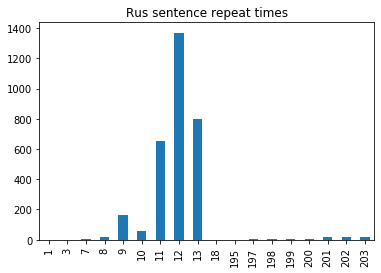

In [6]:
lens = [each[1] for each in seen_rus.items()]
unq = np.unique(lens)
qty = [lens.count(each) for each in unq]
pd.DataFrame(qty, index=unq).plot.bar(title = 'Rus sentence repeat times', legend=False);

#### Most duplicated sentences repeat 12 times, max up to 203 times

### Let's read that data while splitting the tokens. We'll count the tokens in each sentence. If the count in rus and trans is different, we'll record it as anomaly


Anomalies: 49


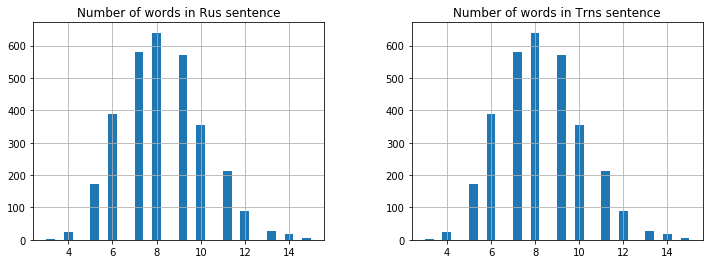

In [7]:
rus_l, trn_l, anomaly = [], [], []
seen = defaultdict(list)
chars = Counter()

for j,i in enumerate(rus_trn):
  rus = i[0].split()
  trn = re.split('#|_|%% %%',i[1])

  if i[0] not in seen:
    if abs(len(rus) - len(trn)) != 0: 
      anomaly.append(j)
      # print(j, ' ', i[0])
      # print( i[1])
    
    else:
      rus_l.append(len(rus))
      trn_l.append(len(trn))

    chars += Counter(i[0])

  seen[i[0]].append(j)

print(f'Anomalies: {len(anomaly)}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

#### So we have 49 anomalies out of 3131 samples

### Let's see if we need to clean the data. First let's take a look at rus corpus alphabet

Number of times "-" used: 159


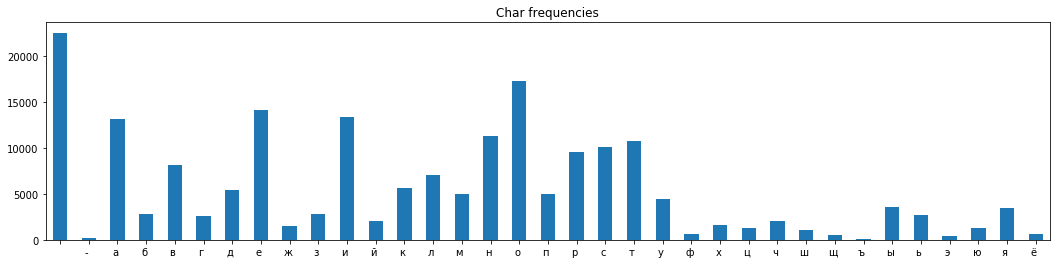

In [8]:
s = sorted(chars.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Char frequencies', legend=False)
print(f'Number of times "-" used: {chars["-"]}')

#### Looks good! We neither have punctuations nor capital letters. The only case to check is '-' letter which is used 159 times

In [9]:
seen = set()
seen_dash = set()
dash_words = []
for rus,trn in rus_trn:
  if rus not in seen:
    if '-' in rus:
      ru_words = rus.split()
      for each in ru_words:
        if '-' in each:
          if each not in seen_dash:
            seen_dash.add(each)
            dash_words.append(each)
  else:
    seen.add(rus)
  
print(dash_words)

['анти-обледенитель', 'иридо-диагностика', 'дом-красавец', 'из-за', 'радио-сигналом', 'ноль-три', 'ноль-два', 'мало-обеспеченные', 'шкаф-купе', 'тех-осмотр', 'пресс-службе', 'авто-сервис', 'чуть-чуть', 'аудио-', 'какие-либо', 'де-факто', 'стерео-', 'царь-колокол', 'царь-пушка', 'гео-магнитного', 'электро-катастрофы', 'фигуристы-новобранцы', 'что-то', 'какое-либо', 'веб-операторы', 'воздушно-десантной', 'военно-морских', 'ветераны-афганцы', 'одного-единственного', 'природно-климатические', 'одном-двух', 'санкт-петербурге', 'стран-участниц', 'пять-шесть', 'по-своему', 'матч-реванш', 'словаря-справочника', 'штаб-квартире', 'чем-то', 'чего-то', 'экс-губернатора', 'российско-американский', 'северо-восточных', 'красно-белую', 'какой-нибудь', 'бело-жёлтый', 'карту-схему', 'юго-западный', 'радио-охранное', 'по-прежнему', 'каким-то', 'кино-картины', 'авто-трюки', 'пресс-конференции', 'генерал-прокурором', 'нью-йорке', 'медиа-группы', 'нью-йоркской', 'какие-то', 'санкт-петербурга', 'санкт-петерб

#### Okey, words with dash look fine, we'll consider dash as a normal letter

### So in order to implement autocoder for transcript we'd need to keep special symbools in transcript such as "\_" and "%% %%". So let's create a dictionary of sentences rus <-> trans. So let's recreate the dictionary so "\_" and "%% %%" are marked with '#' and remove begin and end markers. Plus to that let's get rid of duplicates.


In [0]:
# !pip3 install transliterate
# from transliterate import translit
# translit('длавды дылпадыал лыдап', 'ru', reversed=True)

max len rus: 15, max len trn: 15


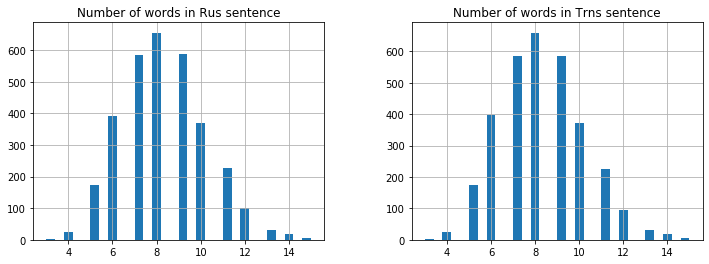

In [63]:
seen_rus = set()
seen_trn = set()

res, trn_l, rus_l = [], [], []
for rus, trn in rus_trn:

  if rus not in seen_rus or trn not in seen_trn:
      seen_rus.add(rus)
      seen_trn.add(trn)

      # trn = trn.replace('%% %%', '%% %% #').replace('_', '_ #')[3:-3]
      # rus_l.append( len(rus))
      # trn_l.append( len(trn.split(' ')))
      # res.append([rus, trn.split(' ')])

      trn = trn.replace('%% %%', '%% %% #').replace('_', '_ #')[2:-2]
      rus_l.append( len(rus.split()))
      trn_l.append( len(trn.split('#')))
      # res.append([rus.split(), ['<sos>'] + trn.split('#'), ['<sos>'] + trn.split('#')])
      res.append([rus.split(), trn.split('#')])

rus_trn_new = array(res)
trn_length = max(trn_l)
rus_length = max(rus_l)
print(f'max len rus: {rus_length}, max len trn: {trn_length}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

In [11]:
rus_trn_new[0]

array([list(['аукционы', 'на', 'дешёвое', 'жильё', 'проводятся', 'регулярно']),
       list(['<sos>', ' a u k ts y o1 n ax ', " n ax' _ ", " d' 'i sh o1 v ax' jax ", " zh y' l' j' 'o1 ", " p r a v o'1 d' 'ax ts ts ax' ", " r' 'ix g u' l' 'a1 r n a "])],
      dtype=object)

### Text to Sequence Conversion

In [0]:
def tokenization(lines, split=' ', char_level=False):
  tokenizer = Tokenizer(filters='', lower=False, split=split, char_level=char_level)
  tokenizer.fit_on_texts(lines)
  return tokenizer

def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(sequences=seq, maxlen=length, padding='post')
  return seq

In [13]:
rus_tokenizer = tokenization(rus_trn_new[:, 0], split='',  char_level=True)
rus_vocab_size = len(rus_tokenizer.word_index) + 1
trn_tokenizer = tokenization(rus_trn_new[:, 1], split=' ', char_level=False)
trn_vocab_size = len(trn_tokenizer.word_index) + 1
print(f'Rus Vocabulary Size: {rus_vocab_size}')
print(f'Trns Vocabulary Size: {trn_vocab_size}')
a = np.random.choice(rus_vocab_size)
print(trn_tokenizer.index_word[a])
print(rus_tokenizer.index_word[a])

Rus Vocabulary Size: 12176
Trns Vocabulary Size: 13891
 u'1 l' 'ix' ch' n ax m 
реестра


### Model Building


In [14]:
rus_trn_new.shape

(3172, 2)

In [64]:
train, test = train_test_split(rus_trn_new, test_size=0.01, random_state = RS)

# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 0])
# trainX_ = encode_sequences(trn_tokenizer, trn_length, train[:, 2])
trainY = encode_sequences(trn_tokenizer, trn_length, train[:, 1])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 0])
# testX_ = encode_sequences(trn_tokenizer, trn_length, test[:, 2])
testY = encode_sequences(trn_tokenizer, trn_length, test[:, 1])

trainX.shape, testX.shape

((3140, 15), (32, 15))

In [66]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print(f'{t} ----> {lang.index_word[t]}')

a = np.random.choice(len(trainX))
convert(rus_tokenizer, trainX[a])
print ()
convert(trn_tokenizer, trainY[a])

1825 ----> столичные
4056 ----> автомобилисты
544 ----> смогут
4057 ----> проехаться
155 ----> над
4058 ----> площадью
4059 ----> гагарина
6 ----> по
4060 ----> эстакаде

1671 ---->  s t a' l' 'i'1 ch' n ax' jax 
4031 ---->  a1 f t ax m ax' b' 'i' l' 'i1 s t ax 
475 ---->  s m o1 g ux t 
4032 ---->  p r a' j' 'e1 h ax ts ts ax 
1672 ---->  n a t _ 
4033 ---->  p l o'1 sh' 'ax' d' j' 'ux 
4034 ---->  g a g a'1 r' 'ix n ax 
16 ---->  p ax _ 
4035 ---->  e s t a k a'1 d' 'e 


#### FastText

In [0]:
from gensim.models.fasttext import FastText
rus_model = FastText(size=20)
trn_model = FastText(size=20)

rus_model.build_vocab(sentences=rus_trn_new[:, 0])
trn_model.build_vocab(sentences=rus_trn_new[:, 1])

total_rus = rus_model.corpus_total_words
total_trn = trn_model.corpus_total_words
print(total_rus, total_trn)

rus_model.train(sentences=rus_trn_new[:,0], total_examples = rus_model.corpus_count, epochs=rus_model.iter)
trn_model.train(sentences=rus_trn_new[:,1], total_examples = trn_model.corpus_count, epochs=trn_model.iter)

print(rus_model.wv['и'])
print(trn_model.wv[" i _ "])

rus_model.wv.similar_by_vector(trn_model.wv[" i _"])
# trn_model.wv.similar_by_vector(rus_model.wv['группа'])

32448 32395


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  del sys.path[0]


[-0.69065756  0.4192582  -1.2095522  -0.01563328 -0.5254309   0.5680641
 -0.65832     0.16494563 -0.406429    0.3612038  -1.1729337   0.1500966
  0.4335361  -0.03284142 -0.88770705  0.15605743  0.08337434 -0.57792157
 -1.086083    0.5548296 ]
[ 0.56364745  0.70111406 -0.36694923  0.05703797 -0.52206254  0.79194874
 -1.2288195  -0.7276088   0.29206008  0.5571377  -0.46059236  0.7377961
 -0.00935896  1.1696087   1.1398089  -0.6379641  -0.2372518  -0.03386954
 -0.6044104   0.5300397 ]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('я', 0.3086957335472107),
 ('ряд', 0.30652180314064026),
 ('им', 0.2938210964202881),
 ('даёт', 0.2934850752353668),
 ('кредит', 0.2921362817287445),
 ('фонд', 0.2906072735786438),
 ('чечни', 0.28800374269485474),
 ('вызывает', 0.28710639476776123),
 ('открытие', 0.28527945280075073),
 ('роль', 0.28502026200294495)]

In [0]:
trn_model.most_similar(' d' 'ix p u t a1 t ')
# rus_model.most_similar('депутат')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(' i _ ', 0.9997418522834778),
 (" b' 'u d zh e1 t ", 0.9996572136878967),
 (" z' _ ", 0.9996542930603027),
 (" n' 'e1 t ", 0.9996196031570435),
 (' e1 t ax ', 0.9996190071105957),
 (" 'i _ ", 0.9996137619018555),
 (" s' _ ", 0.9996098875999451),
 (" d' 'e'1 n' ", 0.9996077418327332),
 (" f s' 'e1 h ", 0.999605119228363),
 (" sh' _ ", 0.9996048212051392)]

### Moving on

In [68]:
trainY[17]

array([5749,  104, 5750, 5751, 5752,  660, 5753,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [71]:
BS = 128
EPOCHES = 500

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(x)
  x, h, c = LSTM(units, return_state=True)(x)
  x = RepeatVector(out_timesteps)(x)
  x = LSTM(units, return_sequences=True)(x, initial_state = (h, c))
  output = TimeDistributed(Dense(out_vocab, activation='softmax'))(x)
  inference_model = model = Model(input, output)
  return model, inference_model

def define_model1(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
   # encoder
  encoder_inputs = Input(shape=(None,))
  encoder_embedding = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)
  encoder = encoder_embedding(encoder_inputs)
  _, state_h, state_c = LSTM(units, return_state=True)(encoder)
  encoder_states = [state_h, state_c]
  # decoder
  decoder_inputs = Input(shape=(None,))
  decoder_embedding = Embedding(out_vocab, units, input_length=out_timesteps, mask_zero=True)
  decoder = decoder_embedding(decoder_inputs)
  decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
  decoder_dense = Dense(out_vocab, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  #inference model
  encoder_model = Model(encoder_inputs, encoder_states)
  decoder_state_input_h = Input(shape=(units,))
  decoder_state_input_c = Input(shape=(units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_inputs_single = Input(shape=(None,))
  decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
  decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
  decoder_states = [h, c]
  decoder_outputs = decoder_dense(decoder_outputs)
  inference_model = Model(
      [decoder_inputs_single] + decoder_states_inputs,
      [decoder_outputs] + decoder_states
  )
  return model, inference_model

model, model_inf = define_model(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 128)
model.summary()

# optimizer = optimizers.RMSprop(lr=0.001)
optimizer=optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

monitor = 'val_loss'
mode = 'min'
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor=monitor, verbose=1, save_best_only=True, mode=mode)
early_stop = EarlyStopping( patience=5, monitor=monitor, mode=mode)

# train model
history = model.fit(trainX, trainY.reshape(*trainY.shape, 1),
# history = model.fit([trainX,trainY], trainY.reshape(*trainY.shape, 1),
                    validation_data=(testX, testY.reshape(*testY.shape, 1)),
                    # validation_data=([testX,trainY], testY.reshape(*testY.shape, 1)),
                    epochs=EPOCHES, batch_size=BS, callbacks=[], 
                    verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 15, 128)      1558528     input_29[0][0]                   
__________________________________________________________________________________________________
lstm_30 (LSTM)                  [(None, 128), (None, 131584      embedding_27[0][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           lstm_30[0

KeyboardInterrupt: ignored

In [61]:
# model = load_model('model.h5')
preds = model_inf.predict(testX)
preds1 = np.argmax(preds,axis=2)
a = np.random.choice(testY.shape[0])
preds[a], testY[a]
convert(trn_tokenizer, preds1[a])
print()
convert(rus_tokenizer, testX[a])


1 ----> <sos>
2 ---->  v _ 

7158 ----> космический
7159 ----> аппарат
7160 ----> передал
7161 ----> сенсационные
2677 ----> снимки


In [27]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == n:
          return word
  return None
  
a = np.random.choice(trn_vocab_size)
t = []
for e in testX[0]:
  s = get_word(e, rus_tokenizer)
  if s: t.append(s)
print( ' '.join(t) )

t = []
for e in testY[0]:
  s = get_word(e, trn_tokenizer)
  if s: t.append(s)
print( '#'.join(t) )

космический аппарат передал сенсационные снимки
<sos># k a s m' 'i'1 ch' 'ix s k' 'ix' j' # 'a p a r a1 t # p' 'ix' r' 'i d a1 l # s' 'ix n s ax ts y o1 n n ax' jax' # s' n' 'i1 m k' 'i 


In [0]:
preds_text = []
prd = preds[:3]
for i in prd:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], trn_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], trn_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t+'#')
    else:
      if(t == None):
            temp.append('')
      else:
              temp.append(t+'#') 

  preds_text.append(''.join(temp))

def unpack(tensor):
  t = []
  for e in tensor:
    s = get_word(e, rus_tokenizer)
    if s: t.append(s)
  return ' '.join(t)

preds_text
# print( list(zip((unpack(e) for e in testX[:3]), preds_text)))
# pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
# pred_df.sample(15)

['', '', '']

In [2]:
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

--2020-02-26 10:59:40--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:3033::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7747747 (7.4M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.39M  24.5MB/s    in 0.3s    

2020-02-26 10:59:40 (24.5 MB/s) - ‘deu-eng.zip’ saved [7747747/7747747]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [15]:
import re
import string
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text
  
# split text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

# download data from http://www.manythings.org/anki/deu-eng.zip
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

# use first 50,000 English-German sentence pairs
deu_eng = deu_eng[:50000,:]

# Text Pre-processing
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,2] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
 
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,2] = '<sos> ' + deu_eng[i,1].lower()
    deu_eng[i,1] = '<sos> ' + deu_eng[i,1].lower()

# Convert text to sequence 
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer( )
    tokenizer.fit_on_texts(lines)
    return tokenizer
  
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines, sos=False, eos=False):

    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)

    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq
  
# model building
# split data 
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainX_ = encode_sequences(deu_tokenizer, deu_length, train[:, 2])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testX_ = encode_sequences(deu_tokenizer, deu_length, test[:, 2])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

English Vocabulary Size: 6345
Deutch Vocabulary Size: 10502


In [0]:
# build NMT model
def define_model1(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  input = x = Input(shape=(None,))
  x = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(x)
  x, h, c = LSTM(units, return_state=True)(x)
  x = RepeatVector(out_timesteps)(x)
  x = LSTM(units, return_sequences=True)(x, initial_state = (h, c))
  output = TimeDistributed(Dense(out_vocab, activation='softmax'))(x)
  inference_model = model = Model(input, output)
  return model, inference_model

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
   # encoder
  encoder_inputs = Input(shape=(None,))
  encoder_embedding = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)
  encoder = encoder_embedding(encoder_inputs)
  _, state_h, state_c = LSTM(units, return_state=True)(encoder)
  encoder_states = [state_h, state_c]
  # decoder
  decoder_inputs = Input(shape=(None,))
  decoder_embedding = Embedding(out_vocab, units, input_length=out_timesteps, mask_zero=True)
  decoder = decoder_embedding(decoder_inputs)
  decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
  decoder_dense = Dense(out_vocab, activation='softmax')
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  #inference model
  encoder_model = Model(encoder_inputs, encoder_states)
  decoder_state_input_h = Input(shape=(units,))
  decoder_state_input_c = Input(shape=(units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_inputs_single = Input(shape=(None,))
  decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
  decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
  decoder_states = [h, c]
  decoder_outputs = decoder_dense(decoder_outputs)
  inference_model = Model(
      [decoder_inputs_single] + decoder_states_inputs,
      [decoder_outputs] + decoder_states
  )
  return model, inference_model

model, model_inf = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
model.summary()
  
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

# train model
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# history = model.fit(trainX, trainY.reshape(*trainY.shape, 1), 
#           validation_data=(testX, testY.reshape(*testY.shape, 1)),
#           epochs=30, batch_size=512, 
#           callbacks=[checkpoint], verbose=1)

history = model.fit([trainX, trainX_], trainY.reshape(*trainY.shape, 1), 
          epochs=30, batch_size=512, 
          validation_data=([testX,testX_], testY.reshape(*testY.shape, 1)),
          callbacks=[checkpoint], verbose=1)

# plot validation loss vs training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

# load saved model
model = load_model('model.h1.24_jan_19')

# make predictions
# preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
# preds = model.predict_classes(testX)

preds_ohe = model_inf.predict(testX)
preds = np.argmax(preds_ohe,axis=2)

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None
  
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))
    
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

# display results
pred_df.sample(15)

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 8, 512)       5377024     input_32[0][0]                   
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 8, 512)       3248640     input_33[0][0]                   
___________________________________________________________________________________________

In [19]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

preds_ohe = model_inf.predict(testX)
preds = np.argmax(preds_ohe,axis=2)

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))
    
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

# display results
pred_df.sample(15)

,actual,predicted
7535,something seems wrong,something seems wrong
7910,i sell computers,i sell computer
3590,youre too inflexible,youre too inflexible
1534,youre not dressed,youre not dressed
2444,the baby is screaming,the baby is in
8949,youre a coward,youre a coward
5977,you look very pale,you look very pale
8768,no kidding,seriously
2450,are we ready for it,are we ready to that
4583,i cant find my pen,i cant find my car


In [0]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = trn_tokenizer.index_word[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [15]:
import numpy as np
i = np.random.choice(len(trainX))
input_seq = trainX[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

NameError: ignored